Wardrobe Wizard Project - MAP 2192 - Holly Darter

Install and import necessary libraries and tools for experiment tracking, PDF manipulation, image conversion, and PyTorch visualization

In [2]:
%%capture
!pip install wandb
!apt-get install poppler-utils
!pip install pdf2image
!pip install flashtorch
import requests
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from torchvision import *
from torchvision.models import *
import wandb as wb

In [3]:
 # Determine the device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to create a GPU tensor with gradient tracking
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)

# Function to create a GPU tensor without gradient tracking
def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)

# Function to plot a grayscale image
def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(5, 5)
    plt.show()

# Function to retrieve Google Slides PDF link from the presentation URL
def get_google_slide(url):
    url_head = "https://docs.google.com/presentation/d/"
    url_body = url.split('/')[5]
    page_id = url.split('.')[-1]
    return url_head + url_body + "/export/pdf?id=" + url_body + "&pageid=" + page_id

# Function to download and convert slides from a Google Slides presentation URL
def get_slides(url):
    url = get_google_slide(url)
    r = requests.get(url, allow_redirects=True)
    open('file.pdf', 'wb').write(r.content)
    images = convert_from_path('file.pdf', 500)
    return images

# Function to load and preprocess an image with PyTorch transformations
def load(image, size=224):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    tensor = transform(image).unsqueeze(0).to(device)
    tensor.requires_grad = True
    return tensor

In [4]:
# Retrieve labels from a JSON file hosted on Amazon S3 and convert them to a dictionary
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

# Instantiate an AlexNet model with pre-trained weights and move it to the specified device (GPU or CPU)
model = alexnet(weights='DEFAULT').to(device)

# Set the model to evaluation mode, which disables dropout layers and ensures consistent inference behavior
model.eval();

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 108MB/s] 


Loading my Google Slides Data Deck

In [5]:
url = "https://docs.google.com/presentation/d/1w-UwMzHvUYb3D-X_rpMsPCt_y8ej8LpBzYM9ql7BFmc/edit#slide=id.p"

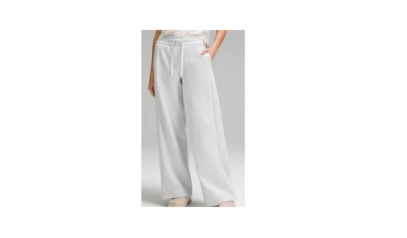

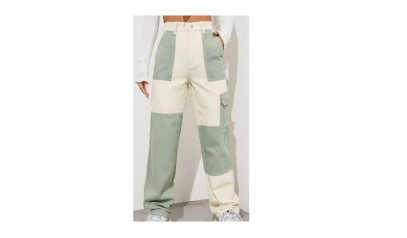

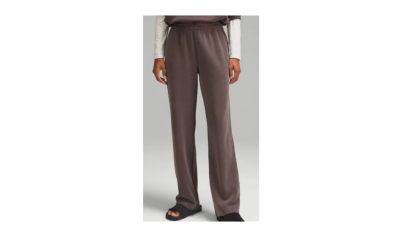

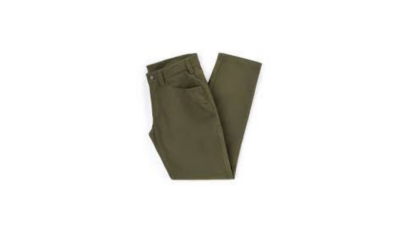

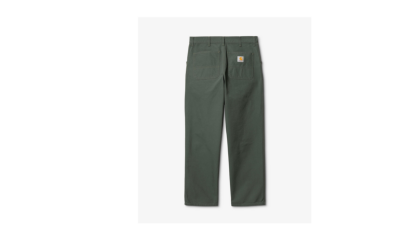

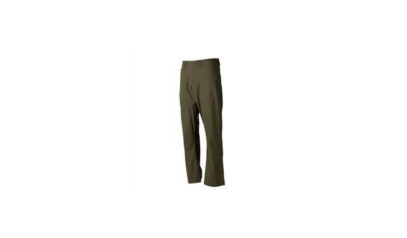

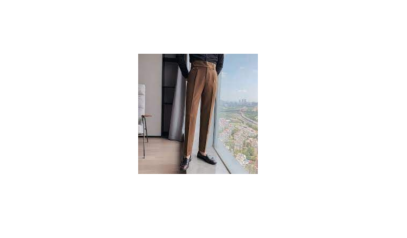

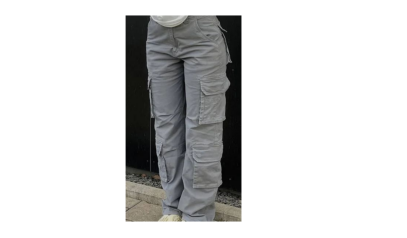

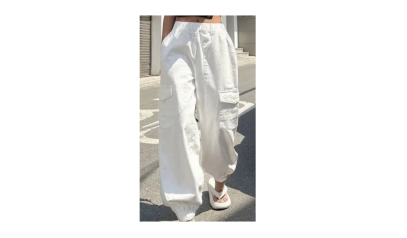

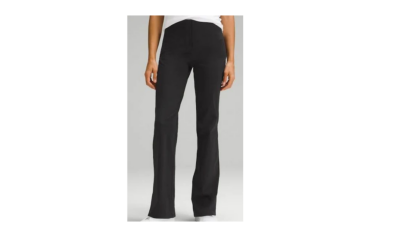

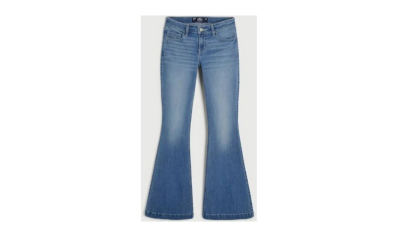

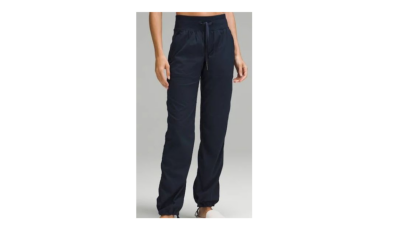

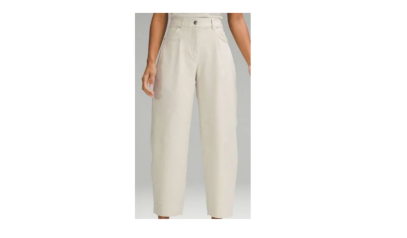

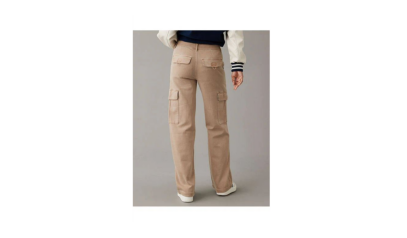

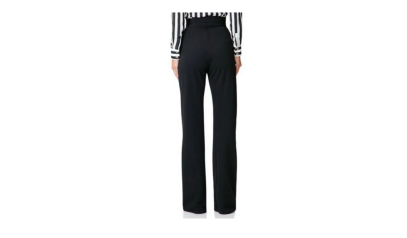

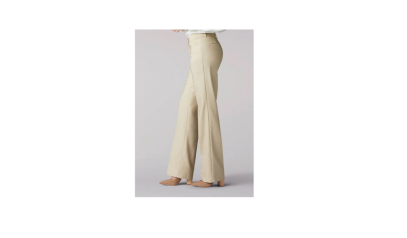

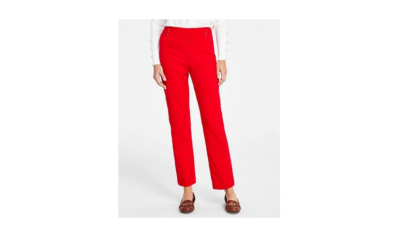

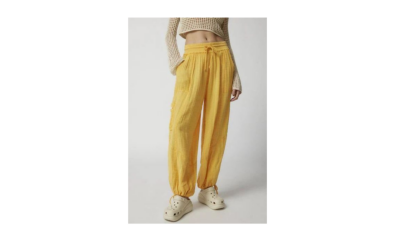

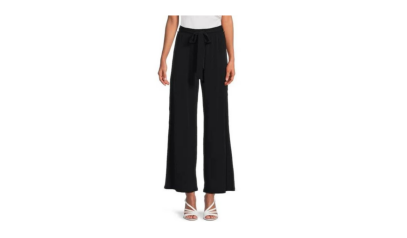

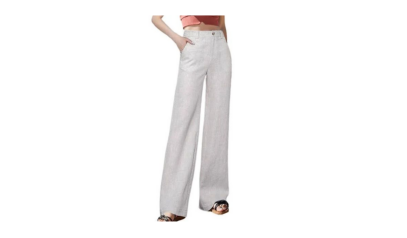

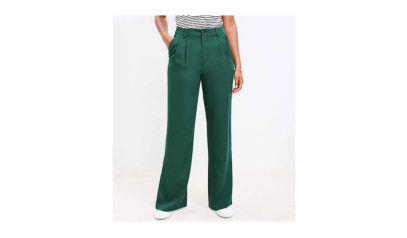

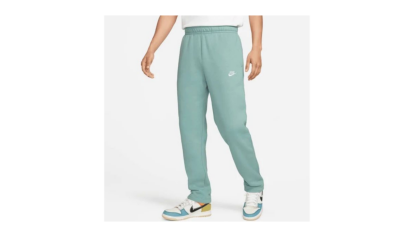

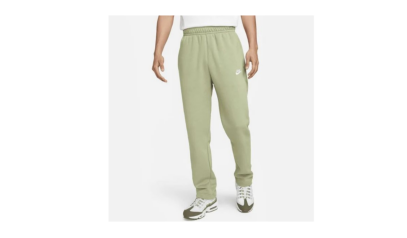

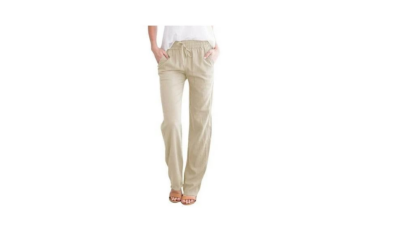

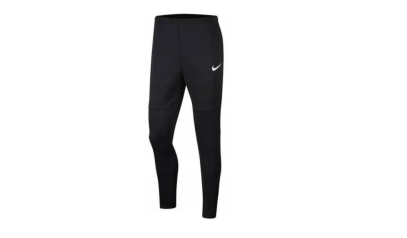

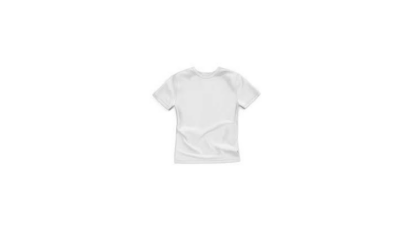

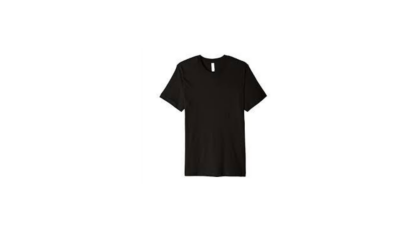

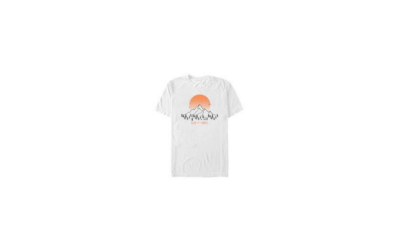

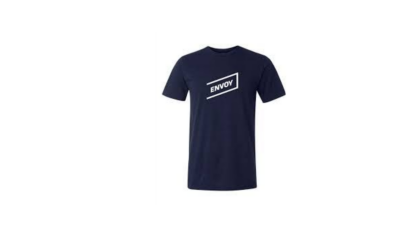

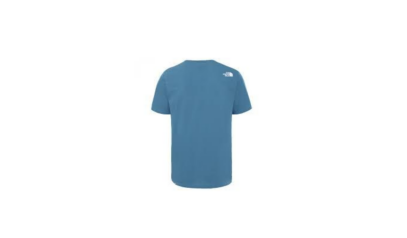

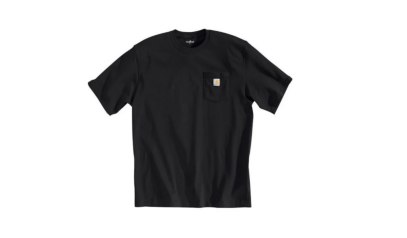

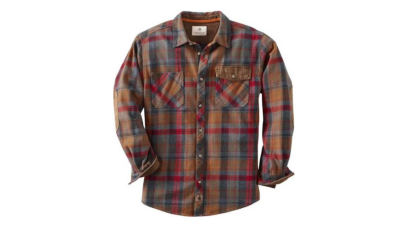

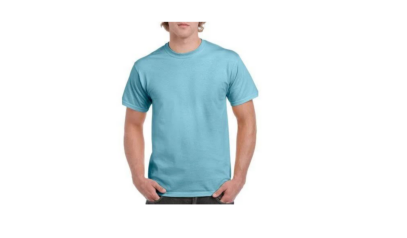

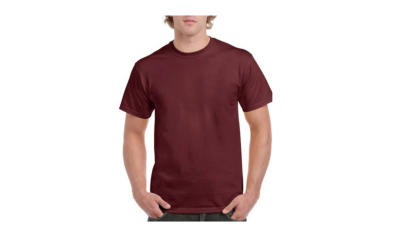

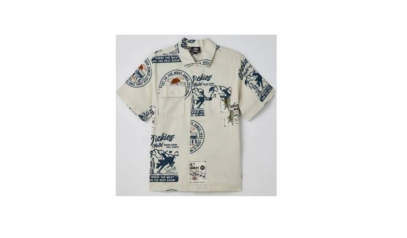

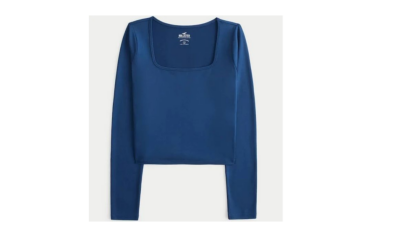

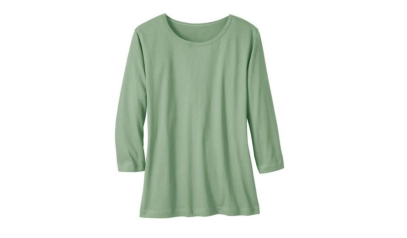

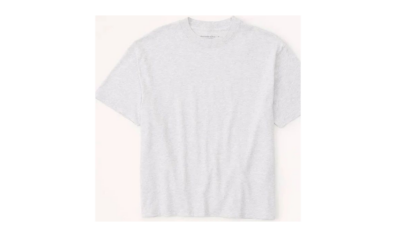

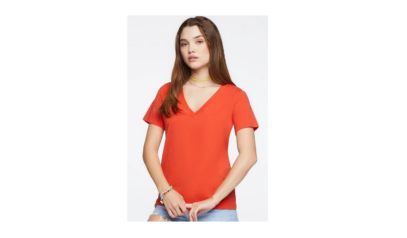

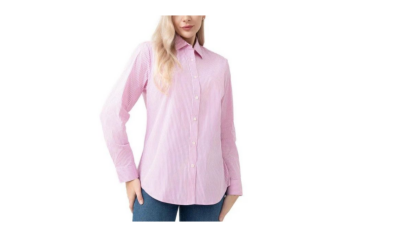

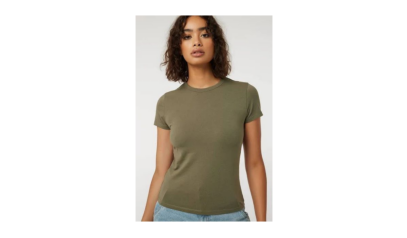

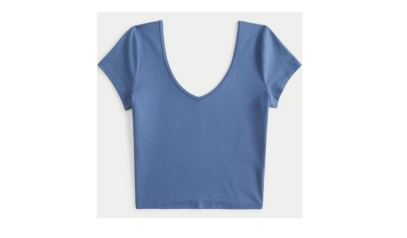

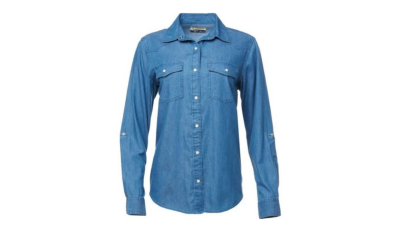

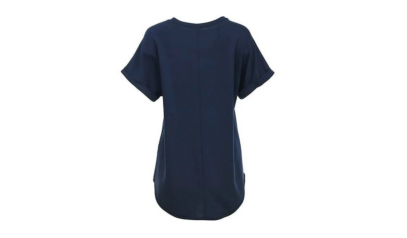

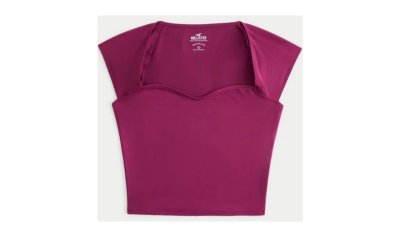

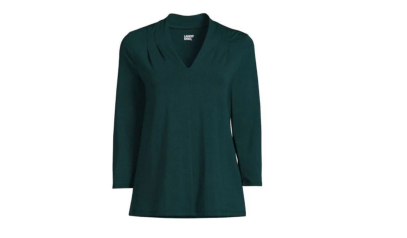

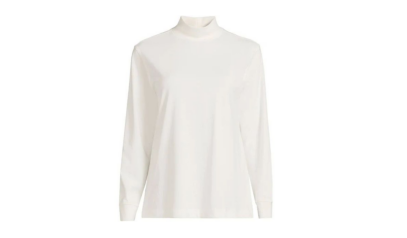

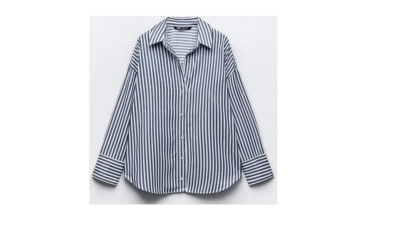

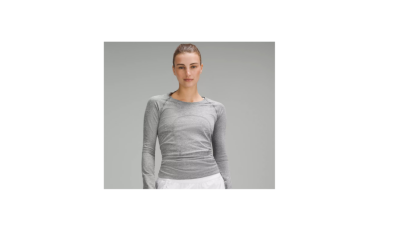

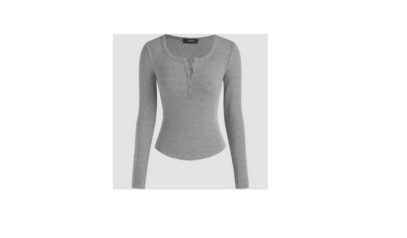

In [6]:
# Initialize an empty list to store images
images = []

# Iterate over images obtained from the Google Slides presentation using the get_slides function
for image in get_slides(url):
  # Plot each image using the plot function
    plot(image)
  # Preprocess and load each image into a PyTorch tensor using the load function
    images.append(load(image))

# Convert the list of PyTorch tensors into a single tensor by vertically stacking them
images = torch.vstack(images)

Obtain the shape of the images tensor, representing the dimensions (batch size, channels, height, width)

In [7]:
images.shape

torch.Size([50, 3, 224, 224])

Perform forward pass of the images through the pre-trained AlexNet model to obtain predictions

In [8]:
model(images)

tensor([[-0.6053,  0.5488, -2.1595,  ..., -5.4571, -2.5499,  5.1501],
        [-1.4064, -0.7581, -3.9292,  ..., -6.3167, -0.4906,  7.8455],
        [-0.6172,  0.5502, -3.6491,  ..., -3.8866, -2.7927,  3.0484],
        ...,
        [ 0.7785, -4.5300, -7.2922,  ..., -4.4489, -1.2538,  6.4997],
        [ 1.6709, -2.3661, -1.5712,  ..., -6.8542, -0.4226,  3.9671],
        [ 0.9178, -1.9001, -1.1212,  ..., -3.4542, -0.7426,  4.4608]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Generate predictions (y) by passing the preprocessed images through the pre-trained AlexNet model

In [9]:
y = model(images)

Obtain the shape of the predictions tensor (y), representing the dimensions (batch size, number of classes)

In [10]:
y.shape

torch.Size([50, 1000])

Extract the class indices with the highest predicted probability for each image

In [11]:
guesses = torch.argmax(y, 1).cpu().numpy()

Print the corresponding labels for each predicted class index in the 'guesses' list

In [12]:
for i in list(guesses):
    print(labels[i])

lab coat, laboratory coat
lab coat, laboratory coat
suit, suit of clothes
envelope
abaya
cleaver, meat cleaver, chopper
table lamp
sleeping bag
can opener, tin opener
suit, suit of clothes
jean, blue jean, denim
jean, blue jean, denim
gown
can opener, tin opener
abaya
table lamp
quill, quill pen
swab, swob, mop
jean, blue jean, denim
lab coat, laboratory coat
jean, blue jean, denim
swimming trunks, bathing trunks
swimming trunks, bathing trunks
maraca
suit, suit of clothes
paper towel
academic gown, academic robe, judge's robe
lotion
jersey, T-shirt, tee shirt
pencil sharpener
jersey, T-shirt, tee shirt
backpack, back pack, knapsack, packsack, rucksack, haversack
jersey, T-shirt, tee shirt
jersey, T-shirt, tee shirt
jersey, T-shirt, tee shirt
academic gown, academic robe, judge's robe
vestment
jersey, T-shirt, tee shirt
maillot
pajama, pyjama, pj's, jammies
maillot, tank suit
bulletproof vest
trench coat
velvet
jersey, T-shirt, tee shirt
suit, suit of clothes
sweatshirt
Windsor tie
swe

Initialize a NumPy array 'Y' of length 50 with all zeros, and set values from index

In [13]:
Y = np.zeros(50,)
Y[25:] = 1

Extract the NumPy array 'X' from the PyTorch tensor 'y' after detaching it from the computation graph and moving it to CPU

In [14]:
X = y.detach().cpu().numpy()

Obtain the shape of the NumPy array 'X', representing the dimensions (batch size, number of classes)

In [15]:
X.shape

(50, 1000)

Plot the values of the first element in the NumPy array 'X' using dots

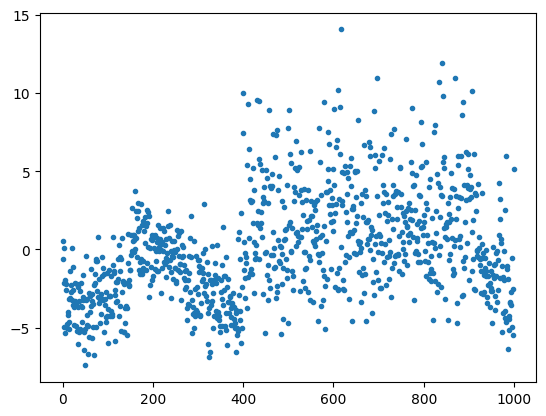

In [16]:
plt.plot(X[0],'.')

Create a histogram of the values in the first element of the NumPy array 'X'

(array([ 29., 154., 242., 262., 144.,  99.,  42.,  19.,   7.,   2.]),
 array([-7.41477394, -5.26839685, -3.12201953, -0.97564238,  1.17073476,
         3.31711197,  5.46348906,  7.60986614,  9.75624371, 11.90262032,
        14.04899788]),
 <BarContainer object of 10 artists>)

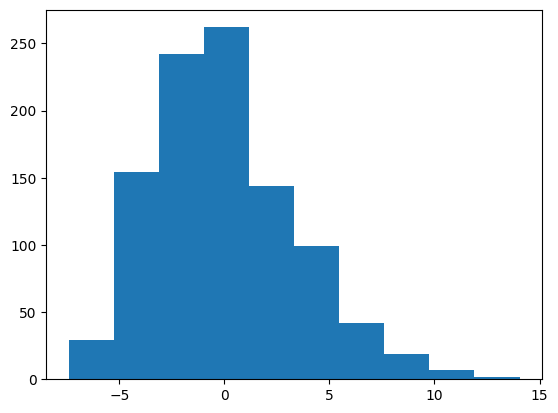

In [17]:
plt.hist(X[0])

Convert NumPy arrays 'X' and 'Y' to GPU tensors without gradient tracking

In [18]:
X = GPU_data(X)
Y = GPU_data(Y)

Define a softmax function to compute the softmax probabilities for each class

In [19]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

Define a cross-entropy loss function for classification

In [20]:
def cross_entropy(outputs, labels):
    # Compute the negative log likelihood of the true class probabilities
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]

Define a function to generate truncated normal random numbers

In [21]:
def randn_trunc(s): #Truncated Normal Random Numbers
  # Set mean and standard deviation for the truncated normal distribution
    mu = 0
    sigma = 0.1

    # Create a truncated normal distribution with specified bounds and parameters
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)

    # Generate 's' random numbers from the truncated normal distribution
    return R.rvs(s)

Define a function to generate random numbers from a truncated normal distribution

In [22]:
def Truncated_Normal(size):

  # Generate random values 'u1' and 'u2' within specified bounds
    u1 = torch.rand(size)*(1-np.exp(-2)) + np.exp(-2)
    u2 = torch.rand(size)

    # Compute random values 'z' from a truncated normal distribution
    z  = torch.sqrt(-2*torch.log(u1)) * torch.cos(2*np.pi*u2)

    return z

Define a function to calculate accuracy between model predictions ('out') and ground truth labels ('y')

In [23]:
def acc(out,y):
  # Use torch.no_grad() to disable gradient computation during accuracy calculation
    with torch.no_grad():
      # Calculate accuracy by comparing predicted and true labels, then normalizing by the batch size
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

Define a function to get a batch of data based on the specified mode (train or test)

In [25]:
def get_batch(mode):
  # Retrieve batch size 'b' from the configuration (assumed to be defined elsewhere as 'c.b')
    b = c.b
    if mode == "train":
       # Randomly select a batch of training data and labels
        r = np.random.randint(X.shape[0]-b)
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
      # Randomly select a batch of testing data and labels
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

Define a simple linear model that performs matrix multiplication between input 'x' and weights 'w[0]'

In [26]:
def model(x,w):

    return x@w[0]

In [30]:
# Define a function to generate and log training accuracy plots using Weights and Biases (WandB)
def make_plots():

  # Calculate training accuracy using the 'model' function
    acc_train = acc(model(x,w),y)

    # Log the training accuracy using Weights and Biases (WandB)
    wb.log({"acc_train": acc_train})

In [28]:
# Initialize Weights and Biases (WandB) for experiment tracking and configuration
wb.init(project="Linear_Model_Photo_1");
c = wb.config

# Set configuration parameters for learning rate, batch size, and number of epochs
c.h = 0.002
c.b = 32
c.epochs =  50000

# Initialize weights using truncated normal random numbers and move to GPU
w = [GPU(Truncated_Normal((1000,2)))]

# Set up the Adam optimizer with the specified learning rate
optimizer = torch.optim.Adam(w, lr=c.h)

# Training loop for the specified number of epochs
for i in range(c.epochs):
  # Get a batch of training data and labels
    x,y = get_batch('train')

# Calculate the cross-entropy loss using the current model and batch
    loss = cross_entropy(softmax(model(x,w)),y)

  # Zero the gradients, perform backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 # Log the current loss using Weights and Biases (WandB)
    wb.log({"loss": loss})

  # Generate and log training accuracy plots
    make_plots()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-3-0b2f4692b34c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)


Finish and close the Weights and Biases (WandB) experiment

In [29]:
wb.finish()

acc_train,▁▃▂█▇████▇███████▇█▇███▇██▇▇█▇████████▇▇
loss,█▆▇▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂
acc_train,0.96875
loss,0.34451
